# U.S. Inaugural data
1. A list of 1 or more contextual datasets you have identified, links to where they reside, and a sentence about why they might be useful in telling the final story.

    All the transcription of U.S. inaugural speech are represented by natural language, which can be read by paragraphs, sentences or words. The data can be obtained from https://avalon.law.yale.edu/subject_menus/inaug.asp . I also plan to integrate google trends for these specific keywords.

2. One paragraph explaining how to use the dashboard you created, to help someone who is not an expert understand your dataset.

    I create a heatmap, where the rows are the presidents (represented by the presidency years), columns are the keywords in their speech. The values of the heatmap are the word frequency in their speech. If we select a cell on the heatmap, the dashboard will tell the word frequency of the selected cell, and the ranking of the presidents for this keyword.



In [2]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from collections import Counter

from nltk.corpus import inaugural
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import FreqDist

import ipywidgets
import bqplot
import pandas as pd

import pytrends

lemmatizer = WordNetLemmatizer()

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
%matplotlib inline

In [3]:
nltk.download('stopwords')
nltk.download('inaugural')
nltk.download('wordnet')

STOP = stopwords.words('english')


[nltk_data] Downloading package stopwords to /home/ran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package inaugural to /home/ran/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def get_pres_id():
    pres_list = inaugural.fileids()
    # name_set = set()
    last_name = None
    result = []
    for line in pres_list:
        year, n = line.rstrip(".txt").split("-")
        if n == last_name:
            last_name = n
            continue
        else:
            last_name = n
            result.append((year, n, line))
    return result
    
year = np.array([int(tri[0]) for tri in get_pres_id()])
year2name = {year: name for year, name, line in get_pres_id()}

# Wordcloud
Let's have a glimpse of the inaugural speech! I created a wordcloud for the corpus. We can know the important (frequent) words in the president speech.

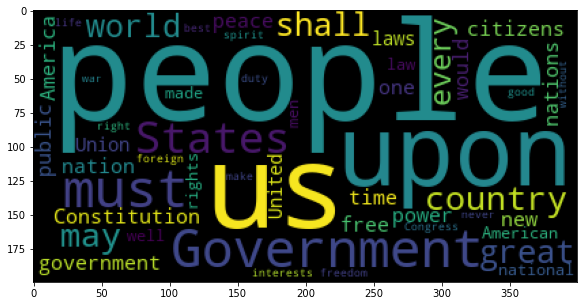

In [5]:
 def create_dic(ids):
     total = []
     for year, name, fileid in ids: 
        words = [w for w in inaugural.words(fileid) if w.isalpha() and w.lower() not in STOP and w not in string.punctuation]
        total.extend(words)
     ctr = Counter(total)
     return ctr
freq = create_dic(get_pres_id())
freq_dic = dict(freq.most_common(50))
wordcloud = WordCloud().generate_from_frequencies(freq_dic)

fig, ax = plt.subplots(figsize=(10,5))        

ax.imshow(wordcloud)
        
plt.show()

In [6]:
kw_list = "justice,democracy,republic,tax,economy,patriotism,god,liberty,crime,wealth,poverty".split(',')
 
def to_kw2d(ids, kw_list):
    x = []
    y = []
    idx = []
    dic = {k: [] for k in kw_list}
    for year, name, fileid in ids:
        idx.append(name)
        words = [lemmatizer.lemmatize(w.lower()) for w in inaugural.words(fileid) if w.isalnum()]
        ctr = Counter(words)
        for k in kw_list:
            dic[k].append(ctr.get(k, 0))
    df = pd.DataFrame(dic, index=idx)
    return df

kw2d = to_kw2d(get_pres_id(),kw_list)

# Keywords frequency - years (corpus)

I am interested in the frequency of some keywords: justice, democracy, republic, tax,economy, patriotism, god, liberty, crime, wealth, poverty

People care about it, so the presidents should mention it in their speech. Then what about their frequency? I create an interactive plot to show the keyword frequency in the inaugural speech. I nomalized the frequency with regard to the total words of each speech.

In [7]:
def keywords(ids, kw):
    x = []
    y = []
    for year, name, fileid in ids:
        
        words = [lemmatizer.lemmatize(w.lower()) for w in inaugural.words(fileid) if w.isalnum()]
        ctr = Counter(words)
        
        cnt = sum([ctr[i] for i in kw])
        all_words = len(inaugural.words(fileid))
        ratio = cnt/all_words
        
        x.append(year)
        y.append(ratio)
    return x, y

@ipywidgets.interact(kw = kw_list)
def kw_in_aug(kw):
    ids = get_pres_id()
    x, y = keywords(ids, [kw])
    fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
    ax.bar(x, y)
    plt.show()

interactive(children=(Dropdown(description='kw', options=('justice', 'democracy', 'republic', 'tax', 'economy'…

# Keywords frequency - years (Google Trends)

The interest of the netizens may varies with the years. To mine what they cares, I crawled data from google trends.

In [8]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)

@ipywidgets.interact(kw = kw_list)
def trend(kw):
    # kw_list = ["tax"]

    pytrends.build_payload([kw], cat=0, timeframe='all', geo='US', gprop='')
    df = pytrends.interest_over_time()
    fig, ax = plt.subplots(1,1)
    df.plot(ax=ax)
    # plt.show()

interactive(children=(Dropdown(description='kw', options=('justice', 'democracy', 'republic', 'tax', 'economy'…

# Interactive with the data!

You can look into the details of the data by the interactive heatmap and get the rank of the presidents for each keyword.

In [9]:
mySelectedLabel = ipywidgets.Label()
y_range = ipywidgets.IntRangeSlider(value=[30,40],
                        min=0,
                        max=len(get_pres_id()),
                        step=1,
                        description="Presidency",
                        disabled=False,
                        continuous_update=False,
                        orientation='horizontal',
                        readout=True)
def updateYAxis(change):
    #Update X-axis min/max value here
    if change['type'] == 'change' and change['name'] == 'value':
        y_sc.domain = year[change['new'][0]:change['new'][1]].tolist()
def on_selected(change): # building
    if len(change['owner'].selected) == 1:
        i, j = change['owner'].selected[0]
        v = np.array(kw2d)[i, j] # CHANGED THIS FOR 3D DATA!!!
        # mySelectedLabel.value = 'word frequency' + str(v)
        # pres_by_key = dict(kw2d[kw_list[j]].sort_values(ascending=False)[:4])
        idx = (-kw2d[kw_list[j]]).argsort()
        pres_by_key = dict(kw2d[kw_list[j]][idx][:4])
        # print(pres_by_key)
        bykey_str =  '\t'.join(k+'='+str(v) for k, v in pres_by_key.items())
        mySelectedLabel.value = 'Selected word frequency=' + str(v) + '. Top presidents of "' + kw_list[j] +'" are ' + bykey_str + ', in ' + ', '.join([str(year[i]) for i in idx][:4])+'.'
        # mySelectedLabel.value = str(kw2d[kw_list[j]][idx][:4])

year = np.array([int(tri[0]) for tri in get_pres_id()])

col_sc = bqplot.ColorScale(scheme="Blues") 

x_sc = bqplot.OrdinalScale()
y_sc = bqplot.OrdinalScale()
y_sc.domain = year[-10:].tolist()

# 3. Axis -- for colors, the axis is a colorbar!
ax_col = bqplot.ColorAxis(scale = col_sc, orientation='vertical', side='right') 
ax_x = bqplot.Axis(scale = x_sc,) # same x/y ax we had before
ax_y = bqplot.Axis(scale = y_sc, orientation='vertical')
# 4. Mark -- heatmap
heat_map = bqplot.GridHeatMap(color = kw2d, row=year,column=kw_list, scales = {'color':col_sc, 'row':y_sc, 'column':x_sc},
                            interactions={'click':'select'},
                            anchor_style={'fill':'blue'},
                            selected_style={'opacity':1.0},
                            unselected_style={'opacity':0.8})
# 5. Interactions -- going to be built into the GridHeatMap mark (how things *look* when selection happens)
# BUT I'm going to define what happens when the interaction takes place (something is selected)
heat_map.observe(on_selected, 'selected')
y_range.observe(updateYAxis)

fig = bqplot.Figure(marks = [heat_map], axes=[ax_col, ax_x, ax_y]) # have to add this axis 
ipywidgets.VBox([y_range,mySelectedLabel,fig])